# Training Notebook

# RSNA 2023 Abdominal Trauma Detection with Pytorch + Lightning

This is just a fork from [KerasCV starter notebook [Train]](https://www.kaggle.com/code/aritrag/kerascv-starter-notebook-train), and corversion to Pytorch + Pytorch lightning.

# Setup and Imports

In [1]:
import os
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
import pytorch_lightning as pl

c:\Users\gabri\miniconda3\envs\ds_gpu\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
import rsna_config as config
from rsna_models import CT_2DModel
from rsna_data import CustomDataset, apply_augmentation, load_image
from rsna_utils import split_group, SimpleLogger
from rsna_visualization import plot_image_gallery, plot_per_task_accuracy, plot_loss, get_best_epoch


## Note on some observations

Reference Notebook: https://www.kaggle.com/code/aritrag/eda-train-csv

1. Class Dependencies: Refers to inherent relationships between classes in the analysis.
2. Complementarity: `bowel_injury` and `bowel_healthy`, as well as `extravasation_injury` and `extravasation_healthy`, are perfectly complementary, with their sum always equal to 1.0.
3. Simplification: For the model, only `{bowel/extravasation}_injury` will be included, and the corresponding healthy status can be calculated using a sigmoid function.
4. Softmax: `{kidney/liver/spleen}_{healthy/low/high}` classifications are softmaxed, ensuring their combined probabilities sum up to 1.0 for each organ, simplifying the model while preserving essential information.

# Dataset

The dataset provided in the competition consists of DICOM images. We will not be training on the DICOM images, rather would work on PNG image which are extracted from the DICOM format.

[A helpful resource on the conversion of DICOM to PNG](https://www.kaggle.com/code/radek1/how-to-process-dicom-images-to-pngs)

In [18]:
BASE_PATH = f"png_data"
# BASE_PATH = f"/kaggle/input/rsna-atd-512x512-png-cropped"
SAVE_PATH = "rsna-atd_ct_2d.pth"

## Meta Data

The `train.csv` file contains the following meta information:

- `patient_id`: A unique ID code for each patient.
- `series_id`: A unique ID code for each scan.
- `instance_number`: The image number within the scan. The lowest instance number for many series is above zero as the original scans were cropped to the abdomen.
- `[bowel/extravasation]_[healthy/injury]`: The two injury types with binary targets.
- `[kidney/liver/spleen]_[healthy/low/high]`: The three injury types with three target levels.
- `any_injury`: Whether the patient had any injury at all.


In [4]:
# train
dataframe = pd.read_csv(f"{BASE_PATH}/train.csv")
dataframe["image_path"] = f"{BASE_PATH}/train_images"\
                    + "/" + dataframe.patient_id.astype(str)\
                    + "/" + dataframe.series_id.astype(str)\
                    + "/" + dataframe.instance_number.astype(str) +".png"
dataframe = dataframe.drop_duplicates()

dataframe.head(2)

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,...,spleen_healthy,spleen_low,spleen_high,any_injury,series_id,instance_number,injury_name,image_path,width,height
0,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,362,Active_Extravasation,png_data/train_images/10004/21057/362.png,512,512
1,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,363,Active_Extravasation,png_data/train_images/10004/21057/363.png,512,512


We split the training dataset into train and validation. This is a common practise in the Machine Learning pipelines. We not only want to train our model, but also want to validate it's training.

A small catch here is that the training and validation data should have an aligned data distribution. Here we handle that by grouping the lables and then splitting the dataset. This ensures an aligned data distribution between the training and the validation splits.

In [5]:
# Initialize the train and validation datasets
train_data = pd.DataFrame()
val_data = pd.DataFrame()

# Iterate through the groups and split them, handling single-sample groups
for _, group in dataframe.groupby(config.TARGET_COLS):
    train_group, val_group = split_group(group)
    train_data = pd.concat([train_data, train_group], ignore_index=True)
    val_data = pd.concat([val_data, val_group], ignore_index=True)

In [6]:
train_data.shape, val_data.shape

((9612, 21), (2417, 21))

## Data Pipeline

In [7]:
paths  = train_data.image_path.tolist()
labels = train_data[config.TARGET_COLS].values

train_dataset = CustomDataset(image_paths=paths, labels=labels)
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
images, labels = next(iter(train_loader))
print("images.shape:", images.shape)
print("labels.shape:", labels.shape)

images.shape: torch.Size([32, 3, 256, 256])
labels.shape: torch.Size([32, 14])


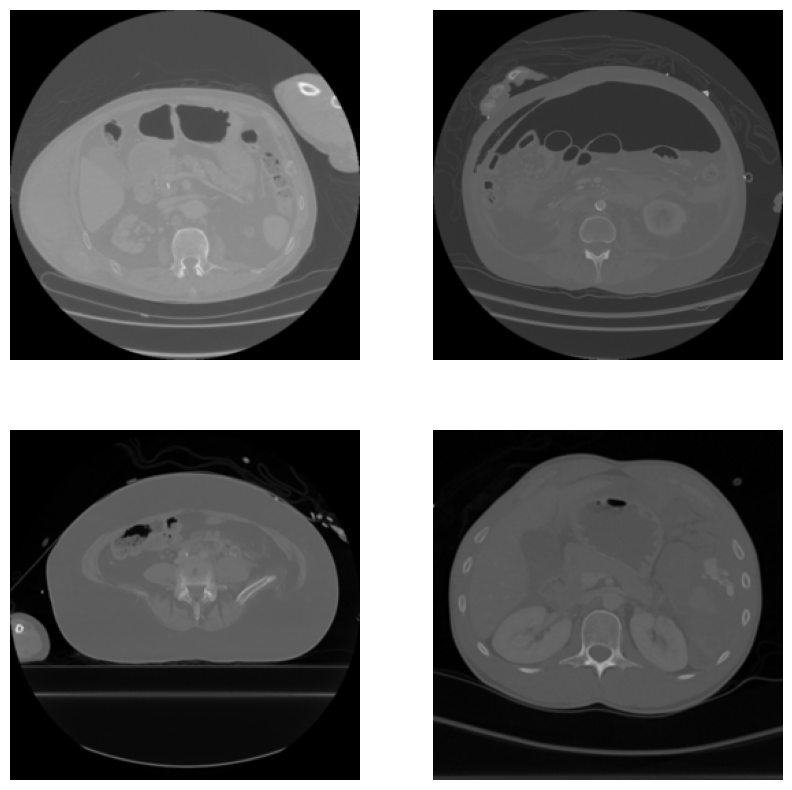

In [8]:
plot_image_gallery(images, value_range=(0, 1), rows=2, cols=2)

# Train the model with "model.fit"

In [9]:
# Get image_paths and labels
train_paths = train_data['image_path'].values
train_labels = train_data[config.TARGET_COLS].values.astype(np.float32)
valid_paths = val_data['image_path'].values
valid_labels = val_data[config.TARGET_COLS].values.astype(np.float32)

# Create train and validation datasets
train_dataset = CustomDataset(image_paths=train_paths, labels=train_labels)
val_dataset = CustomDataset(image_paths=valid_paths, labels=valid_labels)

# Create train and validation data loaders
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE)


In [10]:
logger = SimpleLogger()

In [11]:
# Instantiate the Lightning model
model = CT_2DModel()

# Instantiate the Trainer and train the model
trainer = pl.Trainer(max_epochs=config.EPOCHS, accelerator="auto", logger=logger)
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
c:\Users\gabri\miniconda3\envs\ds_gpu\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:617: UserWarning: Checkpoint directory e:\PersonalProjects\Kaggle\RSNA-ATD\CustomLogger\0\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.
c:\Users\gabri\miniconda3\envs\ds_gpu\Lib\site-packages\pytorch_lig

Sanity Checking: 0it [00:00, ?it/s]

c:\Users\gabri\miniconda3\envs\ds_gpu\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


## Visualize the training plots

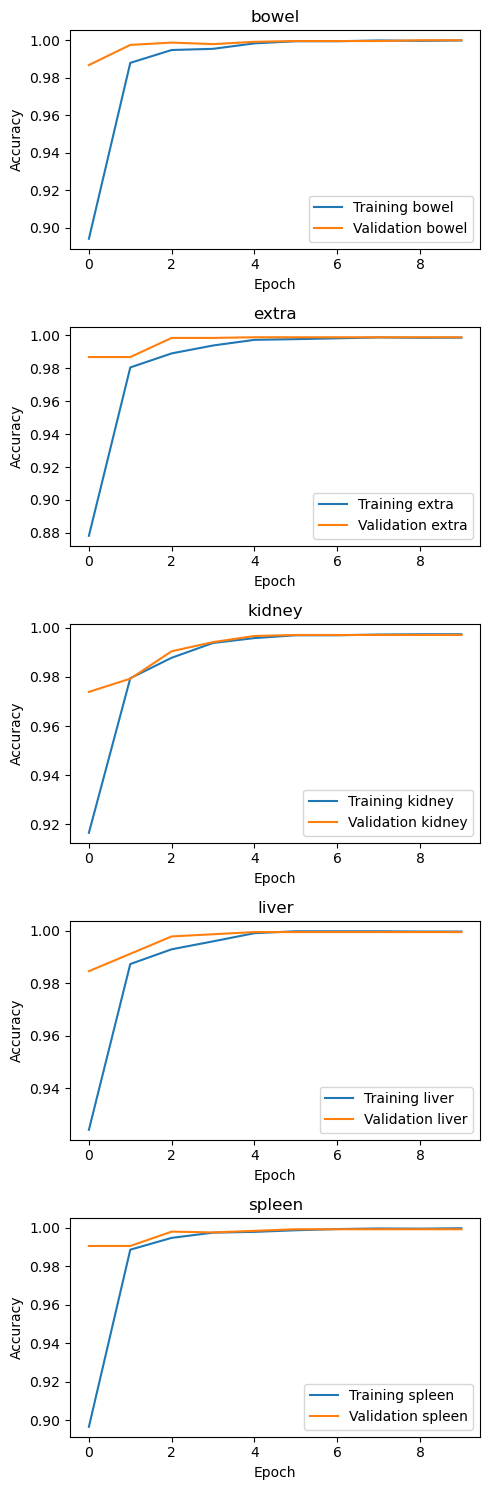

In [12]:
plot_per_task_accuracy(logger)

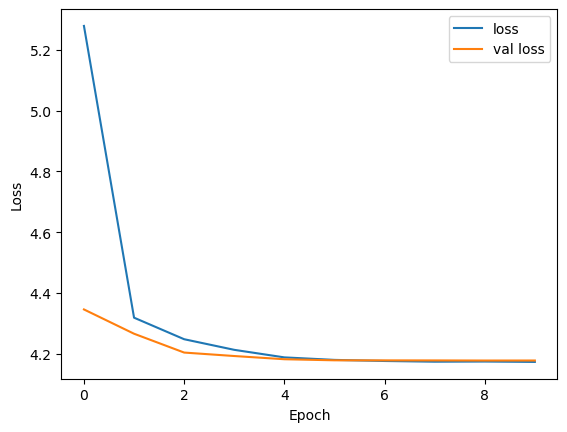

In [13]:
plot_loss(logger)

In [14]:
get_best_epoch(logger)

>>>> BEST Loss  : 4.177
>>>> BEST Acc   : 0.999
>>>> BEST Epoch : 8

ORGAN Acc:
  >>>> Bowel           : 1.000
  >>>> Extravasation   : 0.999
  >>>> Liver           : 1.000
  >>>> Kidney          : 0.997
  >>>> Spleen          : 0.999


In [15]:
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=False)

In [16]:
images, labels = next(iter(train_loader))
image = images[0].unsqueeze(0)
outputs = model(image)
outputs, labels[0].shape

([tensor([[0.2131, 0.7869]], grad_fn=<SoftmaxBackward0>),
  tensor([[8.8543e-04, 9.9911e-01]], grad_fn=<SoftmaxBackward0>),
  tensor([[9.9979e-01, 1.3861e-04, 7.5434e-05]], grad_fn=<SoftmaxBackward0>),
  tensor([[9.9965e-01, 2.7710e-04, 7.5606e-05]], grad_fn=<SoftmaxBackward0>),
  tensor([[9.9808e-01, 7.0867e-04, 1.2114e-03]], grad_fn=<SoftmaxBackward0>),
  tensor([[0.9998]], grad_fn=<RsubBackward1>)],
 torch.Size([14]))

## Store the model for inference

In [19]:
# Save the PyTorch model
trainer.save_checkpoint(SAVE_PATH)

# Inference

- Build an inference model that makes per person inference by averaging across predictions over each CT scan.

In [20]:
test_dataframe = pd.read_csv(f"{BASE_PATH}/test.csv")
test_dataframe.head()

,image_path,patient_id,series_id,instance_number,width,height
0,/kaggle/input/rsna-2023-abdominal-trauma-detec...,63706,39279,30,512,512
1,/kaggle/input/rsna-2023-abdominal-trauma-detec...,50046,24574,30,512,512
2,/kaggle/input/rsna-2023-abdominal-trauma-detec...,48843,62825,30,512,512


In [21]:
# load model if not already loaded
if not "model" in locals():
    model = CT_2DModel.load_from_checkpoint(SAVE_PATH)

model.eval()

predictions = []
for patient in test_dataframe["patient_id"]:
    patient_path = f"{BASE_PATH}/test_images/{patient}"
    session_path = os.path.join(patient_path, os.listdir(patient_path)[0])
    image_path = os.path.join(session_path, os.listdir(session_path)[0])
    image = load_image(image_path)
    image = image.unsqueeze(0)

    prediction = model(image)
    prediction = [p.detach().numpy().tolist()[0] for p in prediction]
    prediction = [item for sublist in prediction for item in sublist]
    predictions.append([patient]+prediction)
    
predictions = pd.DataFrame(predictions, columns=["patient_id"] + config.TARGET_COLS)
predictions.to_csv("submission.csv", index=False)


In [22]:
predictions.head()

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
0,63706,0.999978,0.000022,0.000425,0.999575,0.999888,0.000083,0.000029,0.419951,0.002506,0.577542,0.996154,0.001127,0.002719,0.999822
1,50046,0.999996,0.000004,0.000062,0.999938,0.999340,0.000597,0.000063,0.000287,0.000134,0.999579,0.425741,0.015040,0.559219,1.000000
2,48843,0.999991,0.000009,0.000009,0.999991,0.992850,0.006332,0.000817,0.000004,0.001440,0.998556,0.990628,0.007061,0.002311,1.000000


# Credits

This notebook was forked from https://www.kaggle.com/code/aritrag/kerascv-starter-notebook-train